# From Gradient Boosting to XGBoost

## How gradient boosting works

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the bike_rentals_cleaned data
df_bikes = pd.read_csv('bike_rentals_cleaned.csv')
df_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


In [3]:
X_bikes = df_bikes.iloc[:, :-1]
y_bikes = df_bikes.iloc[:, -1]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bikes, y_bikes, test_size=0.2, random_state=2)

In [4]:
# Initialize a decision tree base learner with a low max_depth. This should not be fine-tuned.
from sklearn.tree import DecisionTreeRegressor
tree_1 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [6]:
# Make predictions with the training set. This will be used to train the meta learner.
y_train_pred = tree_1.predict(X_train)

# Compare the residuals.
y2_train = y_train - y_train_pred

In [7]:
# Train a new model on the residuals. 
tree_2 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_2.fit(X_train, y2_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [8]:
# Repeat the previous process for a third tree.
# This process would typically continue for dozens, hundreds, or thousands of trees, but we're just looking at three.
y2_train_pred = tree_2.predict(X_train)
y3_train = y2_train - y2_train_pred
tree_3 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_3.fit(X_train, y3_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [9]:
# Sum the results of the three trees.
y1_pred = tree_1.predict(X_test)
y2_pred = tree_2.predict(X_test)
y3_pred = tree_3.predict(X_test)

y_pred = y1_pred + y2_pred + y3_pred

In [10]:
# Compute the MSE of the ensemble.
from sklearn.metrics import mean_squared_error as MSE
MSE(y_test, y_pred) ** 0.5

908.19429581485

In [11]:
# Let's try using a gradient boosting model from scikit-learn.
from sklearn.ensemble import GradientBoostingRegressor

# To reproduce our previous results, we'll use hyperparameters that are similar to the ones we used for the decision tree ensemble above.
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=2)

In [12]:
# Fit the model on the training data and view the MSE on the test data.
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred) ** 0.5

908.1942958148497

In [13]:
# The point of gradient boosting is to build enough trees to transform a weak learner into a strong learner.
# This is done by changing n_estimators to a much larger number.
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=30, learning_rate=1.0, random_state=2)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred) ** 0.5

789.4191092437669

In [14]:
# Let's try again with a higher number of estimators.
gbr = GradientBoostingRegressor(
    max_depth=2, n_estimators=300, learning_rate=1.0, random_state=2
)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred) ** 0.5

843.6199641804681

In [15]:
# Did learning_rate=1.0 help or hurt the model? Let's try using sci-kit learn's default learning rate of 0.1.
gbr = GradientBoostingRegressor(
    max_depth=2, n_estimators=300, random_state=2
)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred) ** 0.5

683.8610127962334

## Modifying gradient boosting hyperparameters
`learning_rate` shrinks the contribution of individual trees so that no tree has too much influence when building the model. Typical values are 0.01 or 0.001, and the right choice depends on the problem. The general rule of thumb is that as `n_estimators` goes up, `learning_rate` should go down.

In [23]:
# Let's iterate through different values of learning_rate while holding n_estimators constant.
learning_rate_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1.0]
values = []
rmse_values = []

for value in learning_rate_values:
    gbr = GradientBoostingRegressor(
        max_depth=2, n_estimators=300, learning_rate=value, random_state=2
    )
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred) ** 0.5
    values.append(value)
    rmse_values.append(rmse)
    print('Learning rate: ', value, 'MSE: ', rmse)

Learning rate:  0.001 MSE:  1635.7920144876123
Learning rate:  0.01 MSE:  860.5766368221938
Learning rate:  0.05 MSE:  694.6850944572435
Learning rate:  0.1 MSE:  683.8610127962334
Learning rate:  0.15 MSE:  686.5580342397019
Learning rate:  0.2 MSE:  677.7751819951748
Learning rate:  0.3 MSE:  661.9379260975173
Learning rate:  0.5 MSE:  718.8839059549248
Learning rate:  1.0 MSE:  843.6199641804681


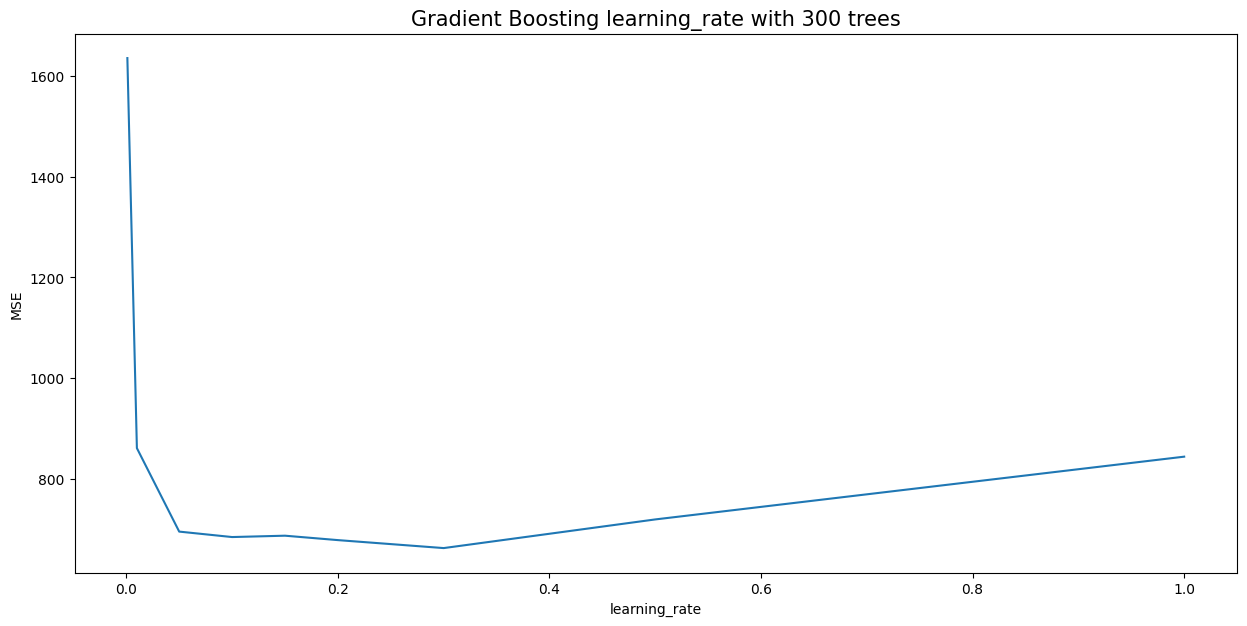

In [27]:
# Create a line plot with learning_rate on the x-axis and MSE on the y-axis.
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.plot(values, rmse_values)
plt.xlabel("learning_rate")
plt.ylabel("MSE")
plt.title("Gradient Boosting learning_rate with 300 trees", fontsize=15)
plt.show()

In [28]:
# Let's iterate through different values of learning_rate while holding n_estimators constant.
learning_rate_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1.0]
values = []
rmse_values = []

for value in learning_rate_values:
    gbr = GradientBoostingRegressor(
        max_depth=2, n_estimators=3000, learning_rate=value, random_state=2
    )
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred) ** 0.5
    values.append(value)
    rmse_values.append(rmse)
    print("Learning rate: ", value, "MSE: ", rmse)

Learning rate:  0.001 MSE:  861.0593581357385
Learning rate:  0.01 MSE:  680.6656404511159
Learning rate:  0.05 MSE:  700.0190850495994
Learning rate:  0.1 MSE:  692.29791904042
Learning rate:  0.15 MSE:  696.7114341926294
Learning rate:  0.2 MSE:  698.7781540606303
Learning rate:  0.3 MSE:  690.6432528356459
Learning rate:  0.5 MSE:  732.3386189417607
Learning rate:  1.0 MSE:  842.5944406017703


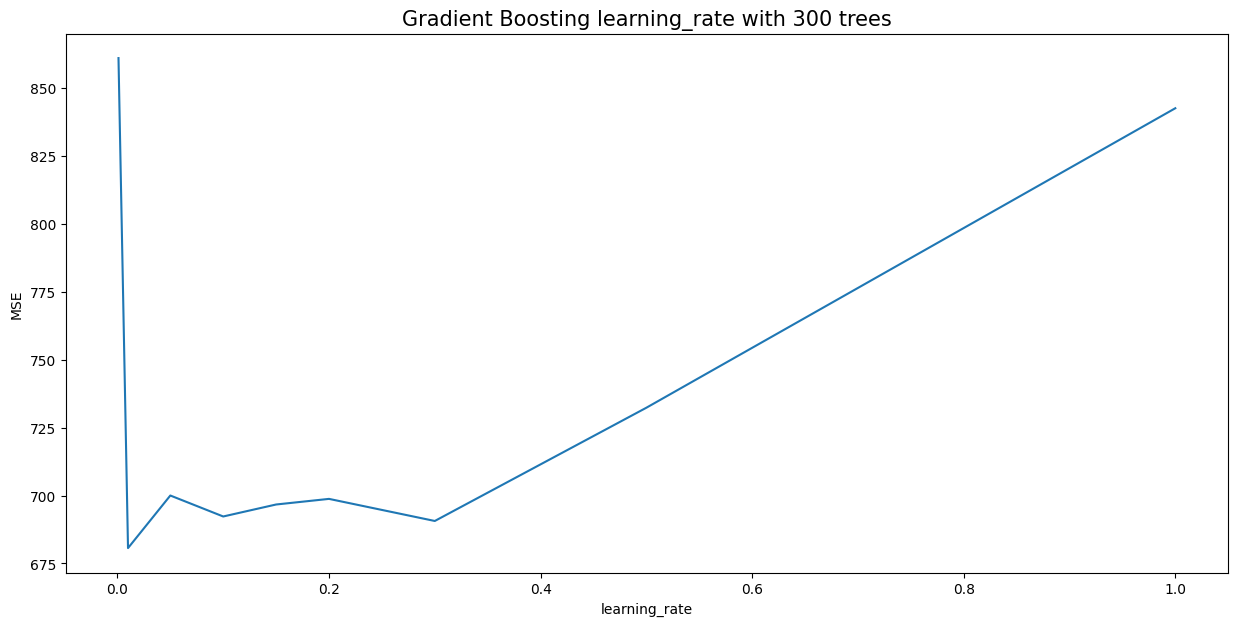

In [29]:
# Visualize the effect of learning_rate on MSE with 3000 trees.
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(values, rmse_values)
plt.xlabel("learning_rate")
plt.ylabel("MSE")
plt.title("Gradient Boosting learning_rate with 300 trees", fontsize=15)
plt.show()

In [30]:
# It's also possible to tune the base learner using max_depth. 
# You can also tune the base learner hyperparamaters covered in chapter 2.
depths = [None, 1, 2, 3, 4]

for depth in depths:
    gbr = GradientBoostingRegressor(max_depth = depth, n_estimators=300, random_state=2)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred) ** 0.5
    print('Max depth: ', depth, 'MSE: ', rmse)

Max depth:  None MSE:  863.6819209797901
Max depth:  1 MSE:  724.7845872142806
Max depth:  2 MSE:  683.8610127962334
Max depth:  3 MSE:  662.8492098164031
Max depth:  4 MSE:  673.6124062806592


In [31]:
# subsample is the fraction of the training set that is used to train each base learner.
# The default value is 1.0, which means that each base learner is trained on the entire training set.
# subsample = 0.8 would select 80% of the training set to train each base learner.
# When subsample != 1.0, the model is classified as a "stochastic gradient boosting model."
samples = [1, 0.9, 0.8, 0.7, 0.6, 0.5]
for sample in samples:
    gbr = GradientBoostingRegressor(max_depth=3, subsample=sample, n_estimators=300, random_state=2)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred) ** 0.5
    print('Subsample: ', sample, 'MSE: ', rmse)

Subsample:  1 MSE:  662.8492098164031
Subsample:  0.9 MSE:  639.2657030362247
Subsample:  0.8 MSE:  624.5698660622177
Subsample:  0.7 MSE:  640.1925282729947
Subsample:  0.6 MSE:  634.3580491542175
Subsample:  0.5 MSE:  621.2259155572428


In [37]:
# We can use a grid search to find the optimal combination of hyperparameters.
# So far we've found that a grid search around max_depth=3, subsample=0.8, learning_rate=0.01, and n_estimators=300 is a good place to start.
# I'm going a little off-book for this one. :)
params = {'subsample': [0.7, 0.725, 0.75, 0.775, 0.8], 'learning_rate': [0.01, 0.02, 0.05, 0.06, 0.07], 'n_estimators': [2000, 2250, 2500, 2750, 3000], 'max_depth': [2, 3, 4, 5, 6, 7, 8]}

# Import RandomizedSearchCV and initialize a model
from sklearn.model_selection import RandomizedSearchCV
gbr = GradientBoostingRegressor(max_depth=3, random_state=2)

# Initialize RandomizedSearchCV with gbr and params plus additional inputs
rand_reg = RandomizedSearchCV(gbr, params, n_iter=10, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, random_state=2)

# Fit the model on the training set and obtain the best parameters and scores
rand_reg.fit(X_train, y_train)
best_model = rand_reg.best_estimator_
best_params = rand_reg.best_params_
print('Best parameters:', best_params)
best_score = np.sqrt(-rand_reg.best_score_)
print(f'Training score: {best_score:.3f}')
y_pred = best_model.predict(X_test)
rmse_test = MSE(y_test, y_pred) ** 0.5
print(f'Test set score: {rmse_test:.3f}')

Best parameters: {'subsample': 0.7, 'n_estimators': 3000, 'max_depth': 2, 'learning_rate': 0.01}
Training score: 617.145
Test set score: 645.990


In [42]:
# Initialize and test the best model from the grid search.
gbr = GradientBoostingRegressor(max_depth=3, n_estimators=3000, learning_rate=0.01, subsample=0.7, random_state=2)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred) ** 0.5

622.9551008077111

In [43]:
# Let's build an XGBRegressor with the same hyperparameters as the GradientBoostingRegressor above.
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=3, n_estimators=3000, learning_rate=0.01, subsample=0.7, random_state=2)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
MSE(y_test, y_pred) ** 0.5

615.608392904602

## Gradient boosting vs XGBoost

In [44]:
df = pd.read_csv('exoplanets_data.csv')
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


In [46]:
df.isnull().sum().sum()

0

In [47]:
# Separate and split the data.
X = df.iloc[:, 1:]
y = df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [48]:
# Import GradientBoostingClassifier, XGBClassifier, and accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [49]:
# Timing models is a good practice.
import time
start = time.time()
df.info()
end = time.time()
elapsed = end - start
print('\nRun time: ' + str(elapsed) + ' seconds.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB

Run time: 0.014816999435424805 seconds.


In [50]:
start = time.time()
gbr = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=2)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('GradientBoostingClassifier accuracy score: ', score)
end = time.time()
elapsed = end - start
print('\nRun time: ' + str(elapsed) + ' seconds.')

GradientBoostingClassifier accuracy score:  0.9874213836477987

Run time: 180.3277189731598 seconds.


In [56]:
# XGBoost requires zero-based classes as of 1.3.2. We'll need to encode the labels.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [57]:
# Let's evaluate an XGBClassifier with the same hyperparameters as the GradientBoostingClassifier above.
start = time.time()
xgb = XGBClassifier(n_estimators=100, max_depth=2, random_state=2)
xgb.fit(X_train.values, y_train_encoded)
y_pred = xgb.predict(X_test)
score = accuracy_score(y_pred, y_test_encoded)
print('XGBClassifier accuracy score: ', score)
end = time.time()
elapsed = end - start
print('\nRun time: ' + str(elapsed) + ' seconds.')

XGBClassifier accuracy score:  0.9913522012578616

Run time: 1.8232789039611816 seconds.
